# Install libraries

In [ ]:
!pip install pyspark
!pip install missingno
!pip install squarify
!pip install geopy
!pip install geocoder


# Import libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp,col,lit, regexp_replace, to_date, unix_timestamp
import pandas as pd
from pyspark.sql.types import *
import missingno as msno
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
import plotly.express as px
import time

from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter, DayLocator

# Setup Spark

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# Get Data

## Data sources

In [3]:
base_url = "https://raw.githubusercontent.com/ZanZver/BigDataManagement/main/Data/"
data_sources = {
  "ad-clicks": f"{base_url}ad-clicks.csv",
  "buy-clicks": f"{base_url}buy-clicks.csv",
  "combined-data": f"{base_url}combined-data.csv",
  "game-clicks": f"{base_url}game-clicks.csv",
  "level-events": f"{base_url}level-events.csv",
  "team-assignments": f"{base_url}team-assignments.csv",
  "team": f"{base_url}team.csv",
  "user-session": f"{base_url}user-session.csv",
  "users": f"{base_url}users.csv",
}

## Load the data

In [4]:
data_loaded = {
  "ad_clicks_pd": pd.read_csv(data_sources["ad-clicks"]),
  "buy_clicks_pd": pd.read_csv(data_sources["buy-clicks"]),
  "combined_data_pd": pd.read_csv(data_sources["combined-data"]),
  "game_clicks_pd": pd.read_csv(data_sources["game-clicks"]),
  "level_events_pd": pd.read_csv(data_sources["level-events"]),
  "team_assignments_pd": pd.read_csv(data_sources["team-assignments"]),
  "team_pd": pd.read_csv(data_sources["team"]),
  "user_session_pd": pd.read_csv(data_sources["user-session"]),
  "users_pd": pd.read_csv(data_sources["users"]),
}

### Date transformation

In [5]:
def convert_date_time_to_unix(data_frame):
    data_frame = pd.to_datetime(data_frame, format='%Y-%m-%d %H:%M:%S')
    data_frame = data_frame.astype(int) // 10**9
    return data_frame

def convert_date_to_unix(data_frame):
    data_frame = pd.to_datetime(data_frame, format='%Y-%m-%d %H:%M:%S')
    data_frame = data_frame.astype(int) // 10**9
    return data_frame

data_frames = ["ad_clicks_pd", "buy_clicks_pd", "game_clicks_pd", "level_events_pd", "team_assignments_pd", 
               "team_pd", "user_session_pd", "users_pd"]
for df_name in data_frames:
    if df_name == "team_pd":
        data_loaded[df_name]["teamEndTime"] = data_loaded[df_name]["teamEndTime"].replace('9999-12-31 23:59:59', "2038-01-19 03:14:07")
        data_loaded[df_name]["teamEndTime"] = convert_date_time_to_unix(data_loaded[df_name]["teamEndTime"])
        data_loaded[df_name]["teamCreationTime"] = convert_date_time_to_unix(data_loaded[df_name]["teamCreationTime"])
    else:
        data_loaded[df_name]["timestamp"] = convert_date_time_to_unix(data_loaded[df_name]["timestamp"])
        
data_loaded["users_pd"]["dob"] = convert_date_time_to_unix(data_loaded["users_pd"]["dob"])


## Split the data

In [ ]:
def split_column(df, col_y):
  x_train, x_test, y_train, y_test = train_test_split(\
                  data_loaded[df].loc[:, data_loaded[df].columns != col_y], \
                  data_loaded[df][col_y])
  return {
      "x_train": x_train,
      "x_test": x_test,
      "y_train": y_train,
      "y_test": y_test
  }

In [ ]:
data_split = {
    "ad_clicks": split_column("ad_clicks_pd", "adCategory"),
    "buy_clicks": split_column("buy_clicks_pd", "price"),
    "combined_data": split_column("combined_data_pd", "count_hits"),
    "game_clicks": split_column("game_clicks_pd", "teamLevel"),
    "level_events": split_column("level_events_pd", "teamLevel"),
    "team_assignments": split_column("team_assignments_pd", "team"),
    "team": split_column("team_pd", "strength"),
    "user_session":  split_column("user_session_pd", "platformType"),
    "users": split_column("users_pd", "country"),
  }

In [ ]:
data_split["ad_clicks"]["y_train"]

## EDA

### Functions

In [6]:
def convert_unix_to_datetime(data_frame, column_name):
    # Check if the column is already a datetime type or is null
    if pd.api.types.is_datetime64_any_dtype(data_frame[column_name]) or pd.isnull(data_frame[column_name]).all():
        return data_frame
    
    data_frame = data_frame.copy()
    # Convert Unix time to datetime object
    data_frame[column_name] = pd.to_datetime(data_frame[column_name], unit='s', errors='coerce')
    
    # Set null values to Unix 32-bit maximum value
    #data_frame[column_name] = data_frame[column_name].fillna(pd.Timestamp(np.datetime64('2038-01-19 03:14:07')))
    
    # Return the updated dataframe
    return data_frame

def generate_timeseries_plot(data_frame, col_1, x_label, y_label, title):
    #data_frame = data_frame.copy()
    # Convert the 'created_utc' column to datetime
    #data_frame[col_1] = pd.to_datetime(data_frame[col_1])
    data_frame = convert_unix_to_datetime(data_frame[[col_1]], col_1)
    
    #data_frame[col_1] = pd.to_datetime(convert_unix_to_datetime(data_frame[[col_1]], col_1))
    #data_frame[col_1] = data_frame.timestamp.apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    #print(data_frame)
    # Group the data by month and count the number of posts per month
    counts = data_frame.groupby(pd.Grouper(key=col_1, freq='D')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts.index, counts.values)

    # Set the x-axis ticks to show every 4 months
    ax.xaxis.set_major_locator(MonthLocator(interval=4))

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

def count_occurrences(items):
    # initialize an empty dictionary to store the counts
    counts = {}
    
    # loop through the items
    for item in items:
        # check if the item is already in the dictionary
        if item in counts:
            # if it is, increment the count by 1
            counts[item] += 1
        else:
            # if it's not, add it to the dictionary with a count of 1
            counts[item] = 1
    
    # convert the dictionary to a DataFrame
    df_counts = pd.DataFrame(list(counts.items()), columns=['item', 'count'])
    
    # return the DataFrame
    return df_counts

def generate_tree_map(data_frame, item_1, item_2, item_1_txt, item_2_txt, title):
    def format_label(item_1_val, item_2_val):
        return f"{item_1_txt}:\n{item_1_val}\n{item_2_txt}:\n{item_2_val}"

    squarify.plot(sizes=data_frame[item_1], 
                label=[format_label(item_1, item_2) for item_1, item_2 
                        in zip(data_frame[item_1], data_frame[item_2])],
                color=sns.color_palette("pastel", len(data_frame)))
    
def create_ad_graph(df):
    adIds_1 = df["adId"]
    adCategories_1 = df["adCategory"]

    # Create a dictionary to store the number of occurrences for each adCategory
    categories_count = {}
    for category in adCategories_1:
        if category not in categories_count:
            categories_count[category] = 0
        categories_count[category] += 1
    
    # Create a list of colors to use for each adCategory
    colors = []
    for category in adCategories_1:
        colors.append('C' + str(list(categories_count.keys()).index(category)))
    
    # Create a dictionary to store the handles and labels for each adCategory
    handles = {}
    for category in categories_count:
        index = list(categories_count.keys()).index(category)
        handles[category] = plt.scatter([], [], c='C' + str(index), label=category)
    
    # Create the scatter plot and legend
    plt.scatter(adIds_1, adCategories_1, c=colors)
    plt.xlabel('adId')
    plt.ylabel('adCategory')
    #plt.legend(handles=handles.values(), labels=handles.keys())
    plt.legend(handles=handles.values(), labels=handles.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def create_histogram(column, num_show):
    # create histogram data
    hist_data = column.value_counts().sort_values(ascending=False).head(num_show)

    # create histogram
    hist = hist_data.plot(kind='bar', width=0.8)

    # customize plot
    plt.xlabel('Team ID')
    plt.ylabel('Count')
    plt.title('Team IDs Histogram')

    # display plot
    plt.show()

def create_correlation_plot(data_frame):
    # create correlation plot
    corr = data_frame.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')

    # display plot
    plt.show()

def create_pie_chart(data_frame):
    # create pie chart data
    pie_data = data_frame.value_counts()

    # create pie chart
    fig, ax = plt.subplots()
    ax.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')

    # customize plot
    ax.set_title('Platform Type Distribution')

    # display plot
    plt.show()

def create_multi_graph(data_frame):
    # group data by platformType and calculate the sum of game clicks and hits
    grouped_data = data_frame.groupby('platformType').sum()

    # create grouped bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, grouped_data['count_gameclicks'], width, label='Game Clicks')
    rects2 = ax.bar(x + width/2, grouped_data['count_hits'], width, label='Hits')

    # customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Counts')
    ax.set_title('Counts by Platform Type')
    ax.legend()

    # display plot
    plt.show()

def create_price_histogram(data_frame):
    # group data by platformType and calculate the average price
    grouped_data = data_frame.groupby('platformType').mean()

    # create bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    fig, ax = plt.subplots()
    ax.bar(x, grouped_data['avg_price'])

    # customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Average Price')
    ax.set_title('Average Price by Platform Type')

    # display plot
    plt.show()
    
def generate_timeseries_plot_2(data_frame, col_1, col_2, x_label, y_label, title):
    # Convert the 'created_utc' column to datetime
    data_frame_1 = convert_unix_to_datetime(data_frame[[col_1]], col_1)
    data_frame_2 = convert_unix_to_datetime(data_frame[[col_2]], col_2)

    # Remove rows that contain datetime value '2038-01-19 03:14:07' in data_frame_1
    data_frame_1 = data_frame_1[data_frame_1[col_1] != pd.to_datetime('2038-01-19 03:14:07')]

    # Remove rows that contain datetime value '2038-01-19 03:14:07' in data_frame_2
    data_frame_2 = data_frame_2[data_frame_2[col_2] != pd.to_datetime('2038-01-19 03:14:07')]

    # Group the data by day and count the number of posts per day
    counts_1 = data_frame_1.groupby(pd.Grouper(key=col_1, freq='D')).size()
    counts_2 = data_frame_2.groupby(pd.Grouper(key=col_2, freq='D')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts_1.index, counts_1.values)
    ax.plot(counts_2.index, counts_2.values, dashes=[4, 4])

    # Set the x-axis ticks to show every day
    ax.xaxis.set_major_locator(DayLocator())

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

def create_team_strenght(data_frame, x_lab, y_lab, asc = False, lim=20):
    # sort, then reset index
    data_frame = data_frame.sort_values('strength', ascending = asc).reset_index(drop=True).head(lim)

    ax = sns.pointplot(x=data_frame.index, y=data_frame.strength)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)

    # Use name column to label x ticks
    _ = ax.set_xticklabels(data_frame.teamId.astype(str).values)

def create_histogram_session(data_frame):
    # group the data by sessionType and platformType, and count the occurrences
    grouped = data_frame.groupby(['sessionType', 'platformType']).size().unstack()

    # create a stacked bar chart
    grouped.plot(kind='bar', stacked=True)

    # set the x-axis label
    plt.xlabel('Platform Type')

    # set the y-axis label
    plt.ylabel('Count')

    # set the title
    plt.title('Session Status by Platform Type')

    # show the chart
    plt.show()

def create_dob_histogram(data_frame):
    # Sample data
    data = {'dob': data_frame}
    df = pd.DataFrame(data)

    # Convert dob to datetime object
    df['dob'] = pd.to_datetime(df['dob'])

    # Extract year from dob
    df['year'] = df['dob'].dt.year

    # Create histogram
    plt.hist(df['year'], bins=10)
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Histogram of Birth Years')
    plt.show()

def prepare_the_countries():
    tmp_data = data_loaded["users_pd"]["country"].to_list()
    tmp_data = [str(x) for x in tmp_data]
    return [x for x in tmp_data if x != 'nan']

def create_world_map():
    # Sample data
    data = {'country': prepare_the_countries()}
    df = pd.DataFrame(data)

    # Initialize geolocator
    geolocator = Nominatim(user_agent="big_data_application")#, timeout=10)

    # Define function to get latitude and longitude from country name
    def get_lat_lon(country):
        try:
          #time.sleep(20)
          location = geolocator.geocode(country)
          return (location.latitude, location.longitude)
        except:
          return (42.1368853, 13.610341022538911)

    # Add the latitude and longitude to the dataframe
    df['lat'], df['lon'] = zip(*df['country'].apply(get_lat_lon))

    # Create dictionary of counts for each country
    counts = df['country'].value_counts().to_dict()

    # Create list of circle sizes for each country
    sizes = [1 * counts[c] for c in df['country']]

    # Create map graph
    fig = px.scatter_geo(df, lat='lat', lon='lon', color='country', size=sizes)
    fig.update_layout(title='Map of Countries')
    fig.show()


### ad clicks

In [8]:
data_loaded["ad_clicks_pd"].head()

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,1464275602,5974,5809,27,611,2,electronics
1,1464275844,5976,5705,18,1874,21,movies
2,1464276172,5978,5791,53,2139,25,computers
3,1464276177,5973,5756,63,212,10,fashion
4,1464276178,5980,5920,9,1027,20,clothing


<AxesSubplot:>

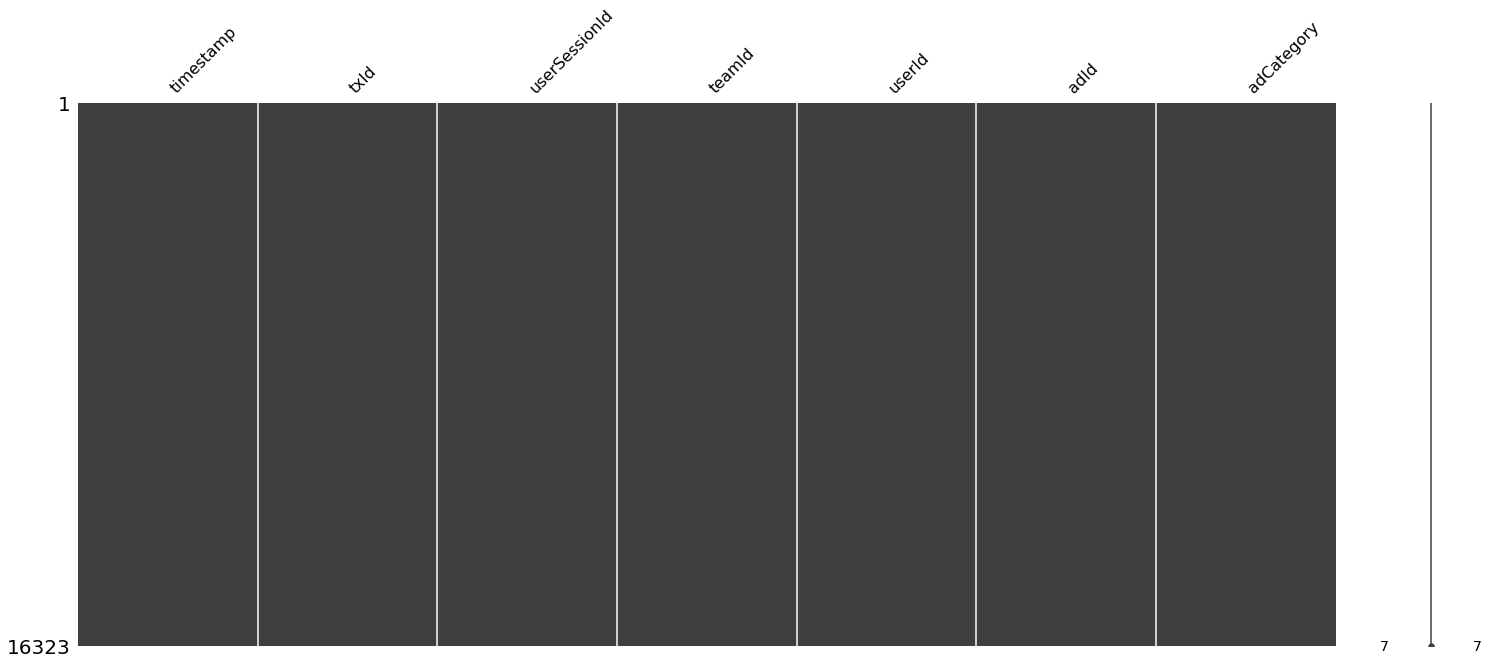

In [9]:
msno.matrix(data_loaded["ad_clicks_pd"])

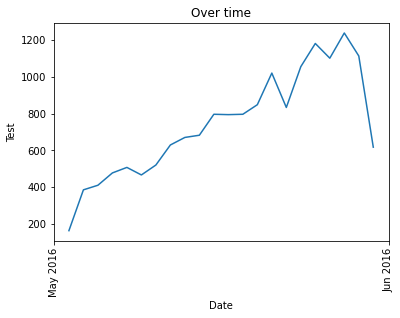

In [10]:
generate_timeseries_plot(data_frame = data_loaded["ad_clicks_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

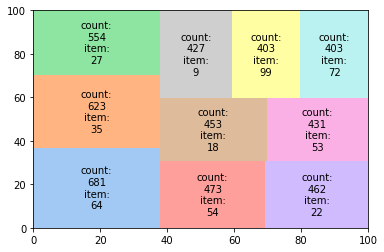

In [11]:
generate_tree_map(count_occurrences(data_loaded["ad_clicks_pd"]["teamId"]).\
                  sort_values(by=['count'], ascending=False).head(10),
                  item_1 = "count",
                  item_2 = "item",
                  item_1_txt= "count",
                  item_2_txt= "item", 
                  title = "Item vs count")

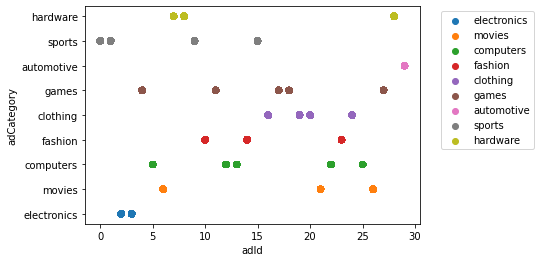

In [12]:
create_ad_graph(data_loaded["ad_clicks_pd"][["adId","adCategory"]])

### buy clicks

In [13]:
data_loaded["buy_clicks_pd"].head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,1464277014,6004,5820,9,1300,2,3.0
1,1464277014,6005,5775,35,868,4,10.0
2,1464277014,6006,5679,97,819,5,20.0
3,1464280614,6067,5665,18,121,2,3.0
4,1464282414,6093,5709,11,2222,5,20.0


<AxesSubplot:>

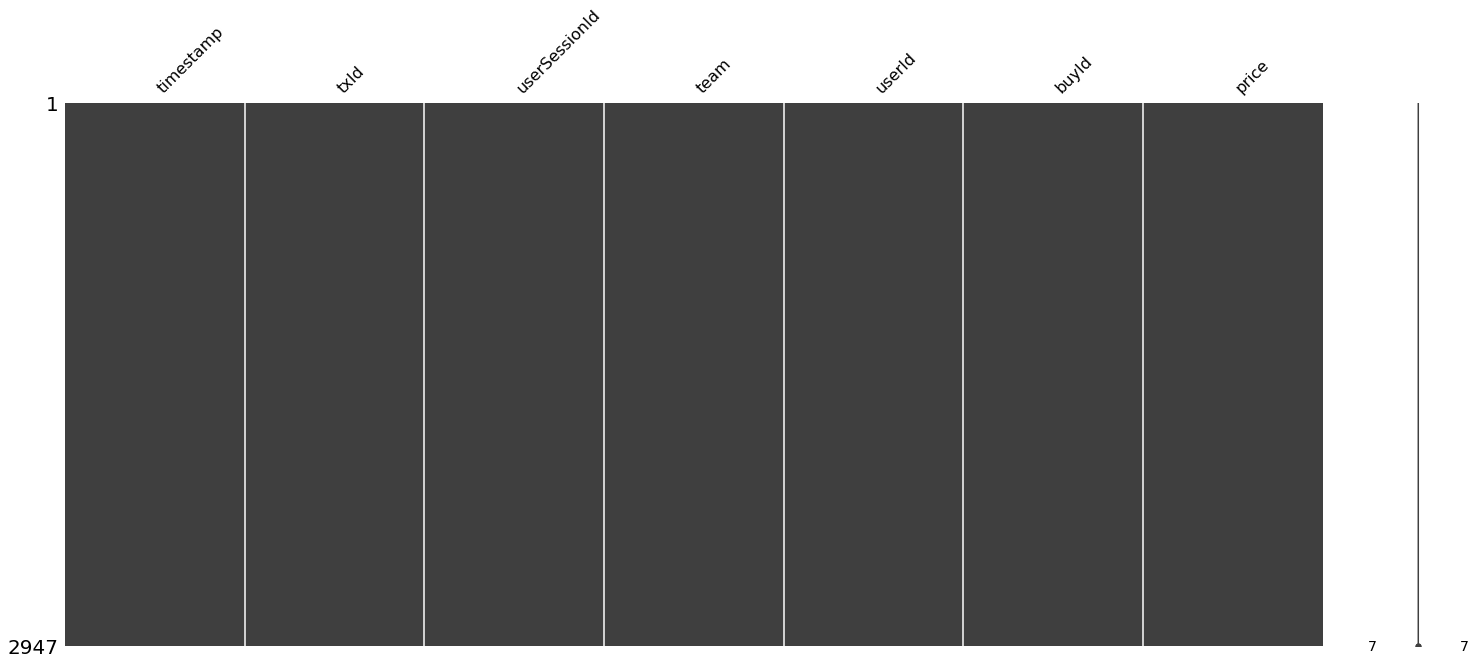

In [14]:
msno.matrix(data_loaded["buy_clicks_pd"])

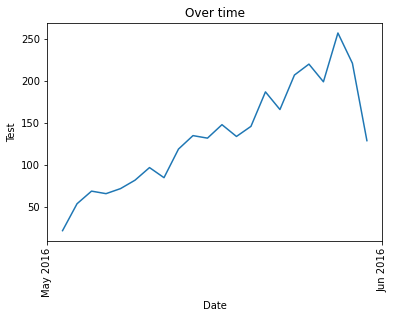

In [15]:
generate_timeseries_plot(data_frame = data_loaded["buy_clicks_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

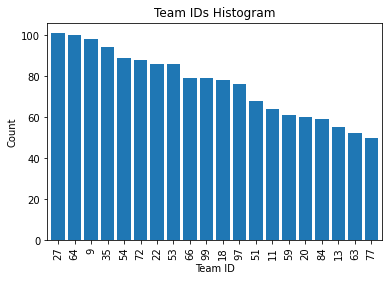

In [16]:
create_histogram(column = data_loaded["buy_clicks_pd"]["team"], num_show=20)

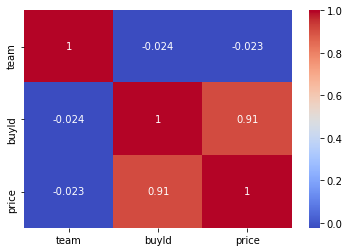

In [17]:
create_correlation_plot(data_loaded["buy_clicks_pd"][["team","buyId", "price"]])

### combined data

In [18]:
data_loaded["combined_data_pd"].head()

,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price
0,812,5648,1,android,69,8,NaN,NaN
1,1658,5649,1,iphone,31,5,NaN,NaN
2,1589,5650,1,iphone,26,2,NaN,NaN
3,1863,5651,1,android,35,4,NaN,NaN
4,937,5652,1,android,39,0,1.0,1.0


<AxesSubplot:>

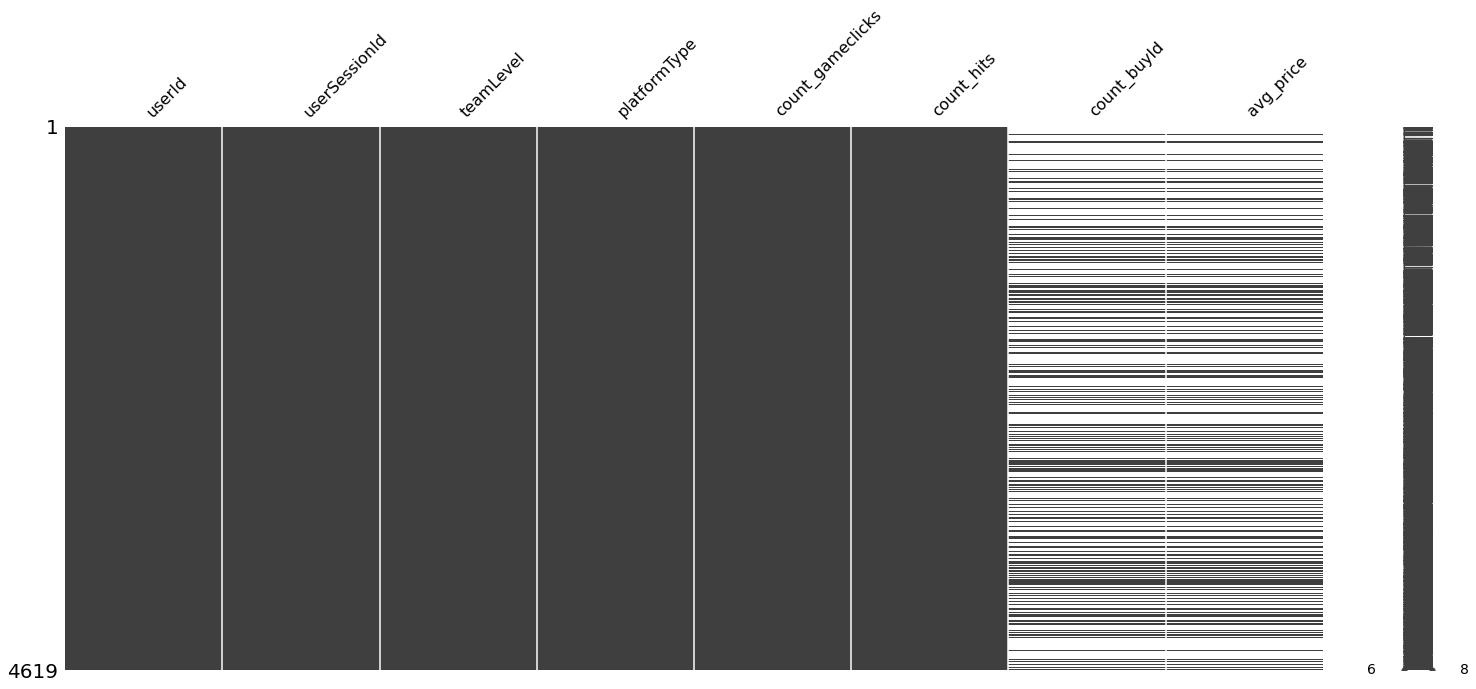

In [19]:
msno.matrix(data_loaded["combined_data_pd"])

In [20]:
data_loaded["buy_clicks_pd"][["team","buyId", "price"]].head(10)

,team,buyId,price
0,9,2,3.0
1,35,4,10.0
2,97,5,20.0
3,18,2,3.0
4,11,5,20.0
5,77,5,20.0
6,9,5,20.0
7,35,2,3.0
8,64,5,20.0
9,35,1,2.0


In [21]:
data_loaded["combined_data_pd"][["platformType","avg_price"]].head(10)

,platformType,avg_price
0,android,NaN
1,iphone,NaN
2,iphone,NaN
3,android,NaN
4,android,1.0
5,android,NaN
6,iphone,NaN
7,windows,NaN
8,android,NaN
9,iphone,NaN


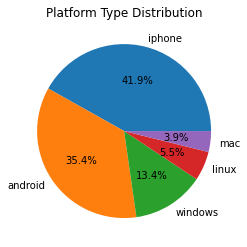

In [22]:
create_pie_chart(data_frame = data_loaded["combined_data_pd"]["platformType"])

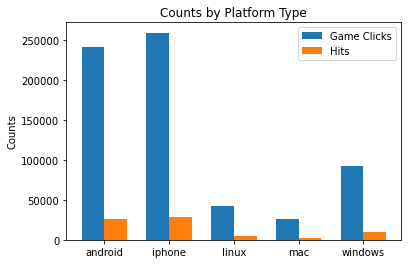

In [23]:
create_multi_graph(data_frame=data_loaded["combined_data_pd"][["platformType","count_gameclicks","count_hits"]])

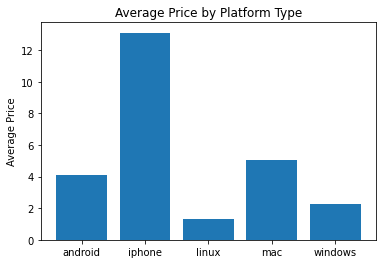

In [24]:
create_price_histogram(data_frame=data_loaded["combined_data_pd"][["platformType","avg_price"]])

### game clicks

In [25]:
data_loaded["game_clicks_pd"].head()

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,1464275215,105,1038,5916,0,25,1
1,1464275229,154,1099,5898,0,44,1
2,1464275234,229,899,5757,0,71,1
3,1464275234,322,2197,5854,0,99,1
4,1464275240,22,1362,5739,0,13,1


<AxesSubplot:>

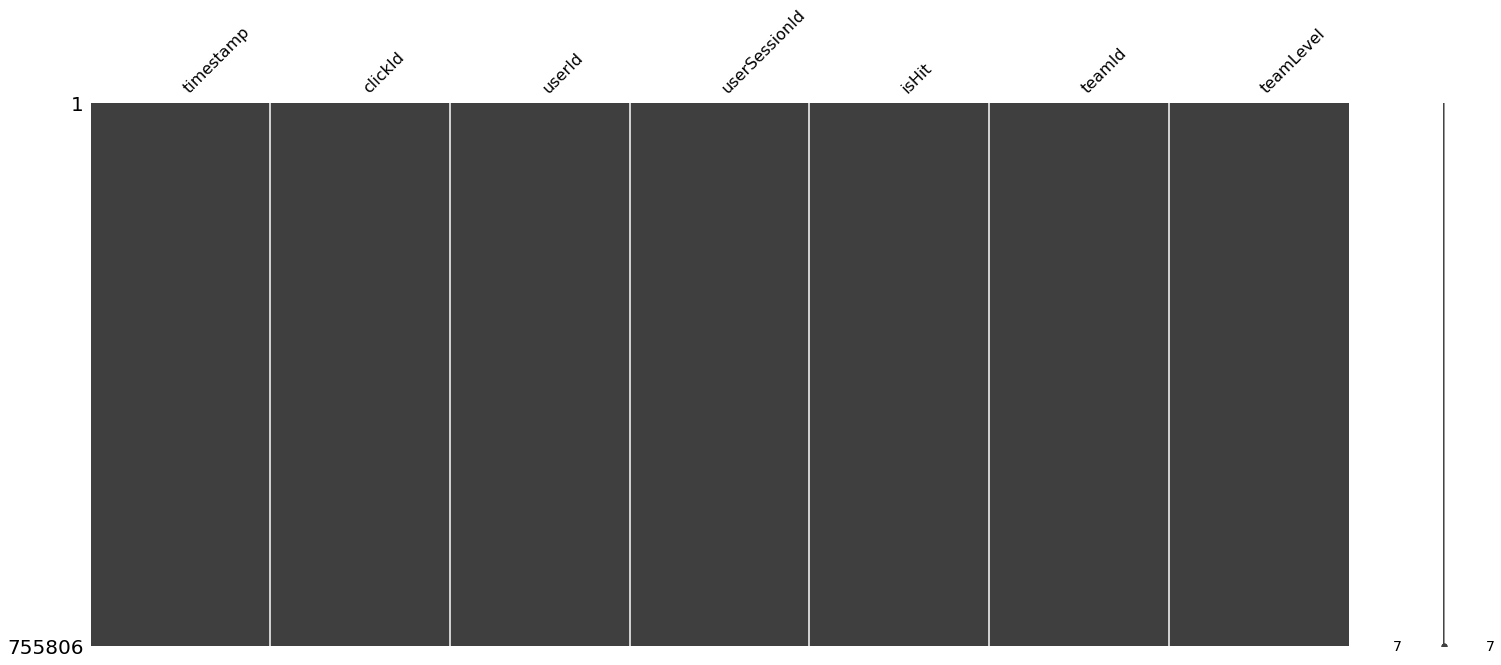

In [26]:
msno.matrix(data_loaded["game_clicks_pd"])

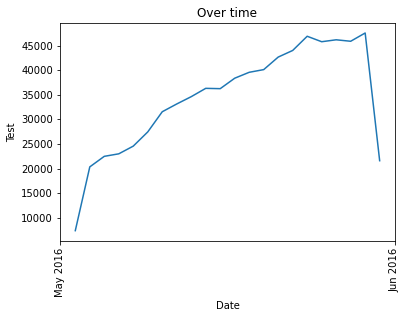

In [27]:
generate_timeseries_plot(data_frame = data_loaded["game_clicks_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

### level events

In [28]:
data_loaded["level_events_pd"].head()

,timestamp,eventId,teamId,teamLevel,eventType
0,1464390414,0,2,1,end
1,1464390414,1,2,2,start
2,1464390414,2,8,1,end
3,1464390414,3,8,2,start
4,1464390414,4,9,1,end


<AxesSubplot:>

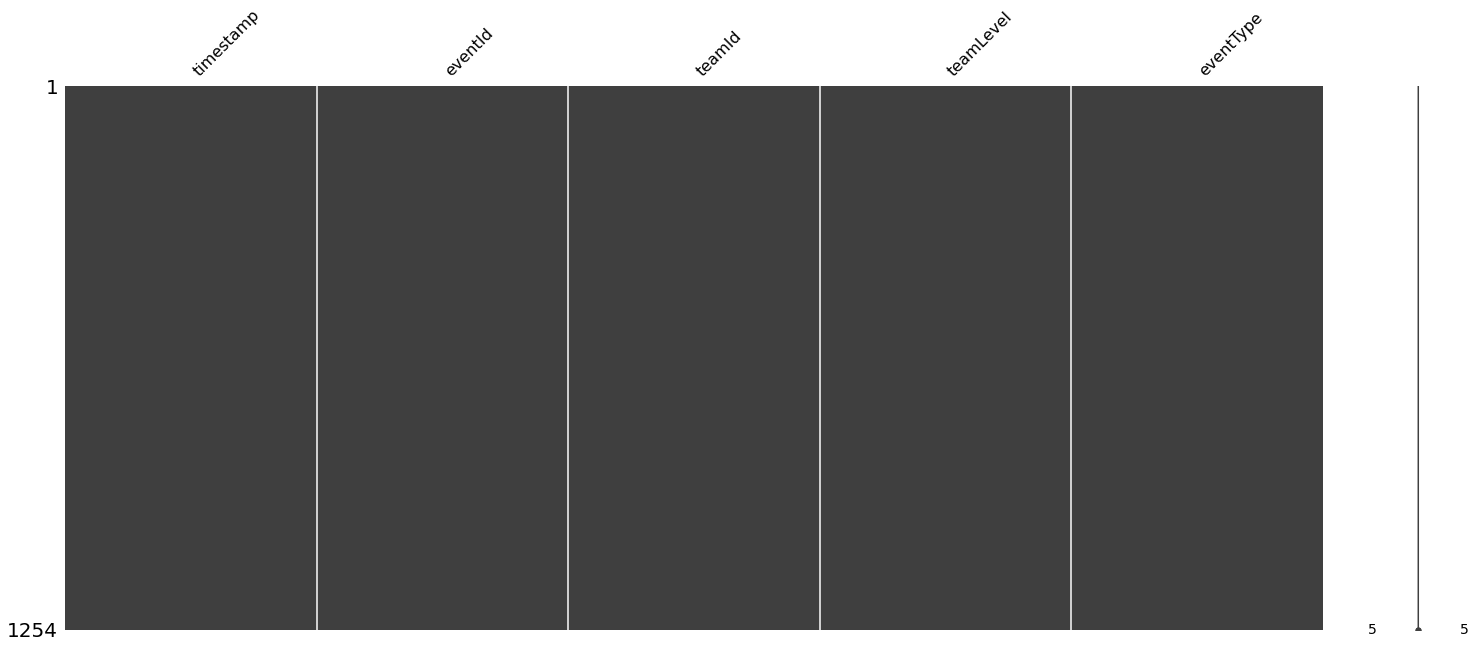

In [29]:
msno.matrix(data_loaded["level_events_pd"])

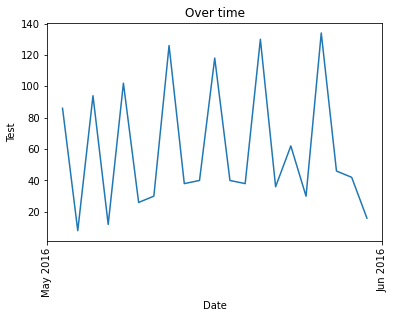

In [30]:
generate_timeseries_plot(data_frame = data_loaded["level_events_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

In [31]:
data_loaded["level_events_pd"][["eventType","teamLevel"]].head(30)

,eventType,teamLevel
0,end,1
1,start,2
2,end,1
3,start,2
4,end,1
5,start,2
6,end,1
7,start,2
8,end,1
9,start,2


### team assignments

In [32]:
data_loaded["team_assignments_pd"].head()

,timestamp,team,userId,assignmentId
0,1464271614,64,504,5439
1,1464271620,39,1698,5301
2,1464271624,85,81,5540
3,1464271628,95,1976,5307
4,1464271629,97,1009,5368


<AxesSubplot:>

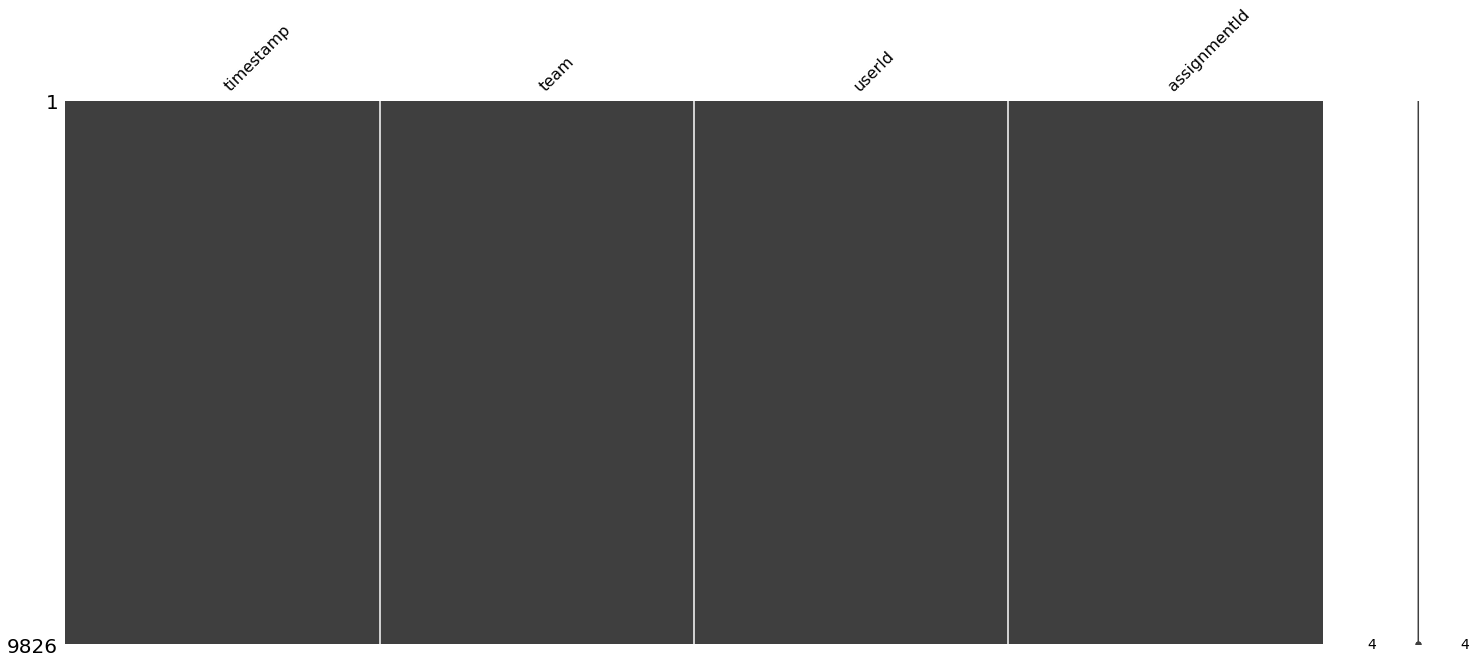

In [33]:
msno.matrix(data_loaded["team_assignments_pd"])

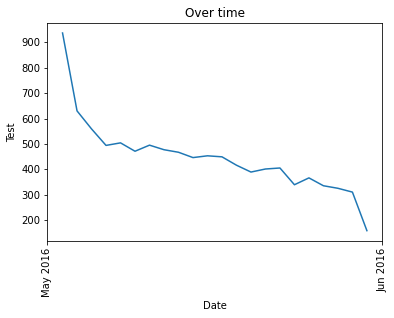

In [34]:
generate_timeseries_plot(data_frame = data_loaded["team_assignments_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

### team

In [35]:
data_loaded["team_pd"].head()

,teamId,name,teamCreationTime,teamEndTime,strength,currentLevel
0,79,O1uJX7C,1465745607,2147483647,0.774474,1
1,92,WeLHp8HZ,1465768460,2147483647,0.171926,1
2,6,mARlfz,1465772536,2147483647,0.537353,1
3,7,xO41jlAo0Y,1465797783,2147483647,0.394370,1
4,40,vdwO0k1,1465801263,2147483647,0.706833,1


<AxesSubplot:>

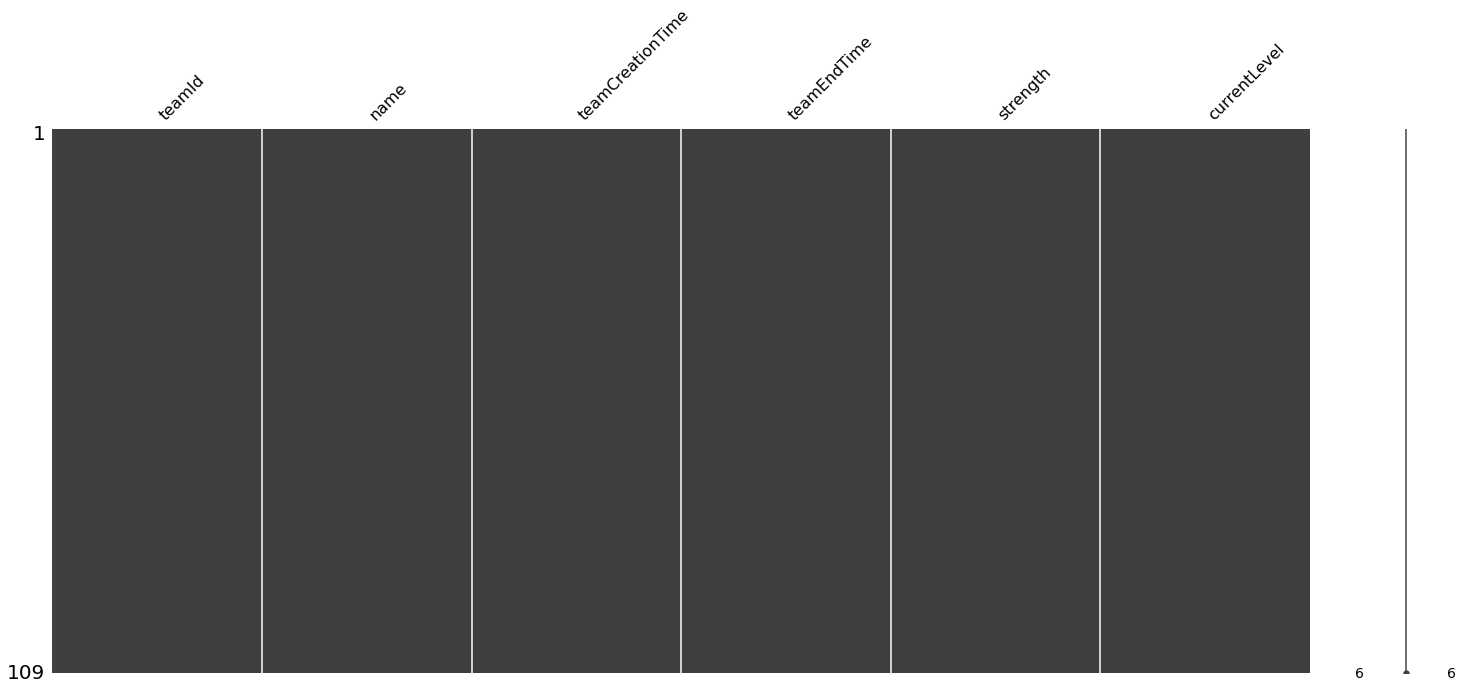

In [36]:
msno.matrix(data_loaded["team_pd"])

In [37]:
data_loaded["team_pd"][["teamCreationTime","teamEndTime"]].head()

,teamCreationTime,teamEndTime
0,1465745607,2147483647
1,1465768460,2147483647
2,1465772536,2147483647
3,1465797783,2147483647
4,1465801263,2147483647


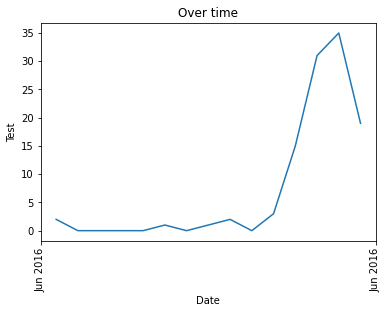

In [38]:
generate_timeseries_plot(data_frame = data_loaded["team_pd"], col_1="teamCreationTime", x_label = "Date", y_label = "Test", title = "Over time")

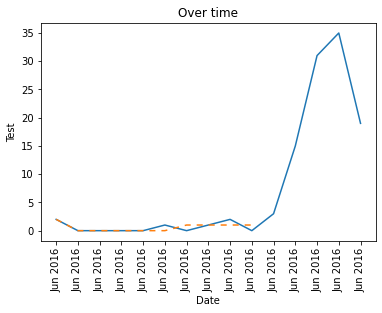

In [39]:
generate_timeseries_plot_2(data_frame = data_loaded["team_pd"], col_1="teamCreationTime", col_2="teamEndTime", x_label = "Date", y_label = "Test", title = "Over time")

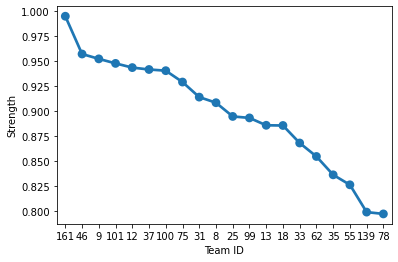

In [40]:
create_team_strenght(data_frame=data_loaded["team_pd"], x_lab="Team ID", y_lab="Strength")

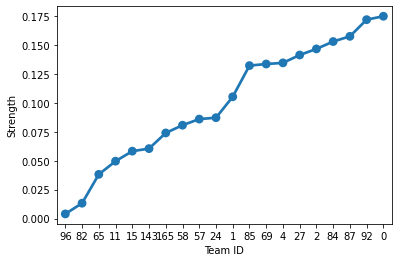

In [41]:
create_team_strenght(data_frame=data_loaded["team_pd"], x_lab="Team ID", y_lab="Strength",asc = True)

### user session

In [42]:
data_loaded["user_session_pd"].head()

,timestamp,userSessionId,userId,teamId,assignmentId,sessionType,teamLevel,platformType
0,1464274050,5675,170,90,5423,start,1,iphone
1,1464307614,5675,170,90,5423,end,1,iphone
2,1464273789,5795,835,39,5300,start,1,android
3,1464336414,5795,835,39,5300,end,1,android
4,1464274040,5833,624,2,5529,start,1,iphone


<AxesSubplot:>

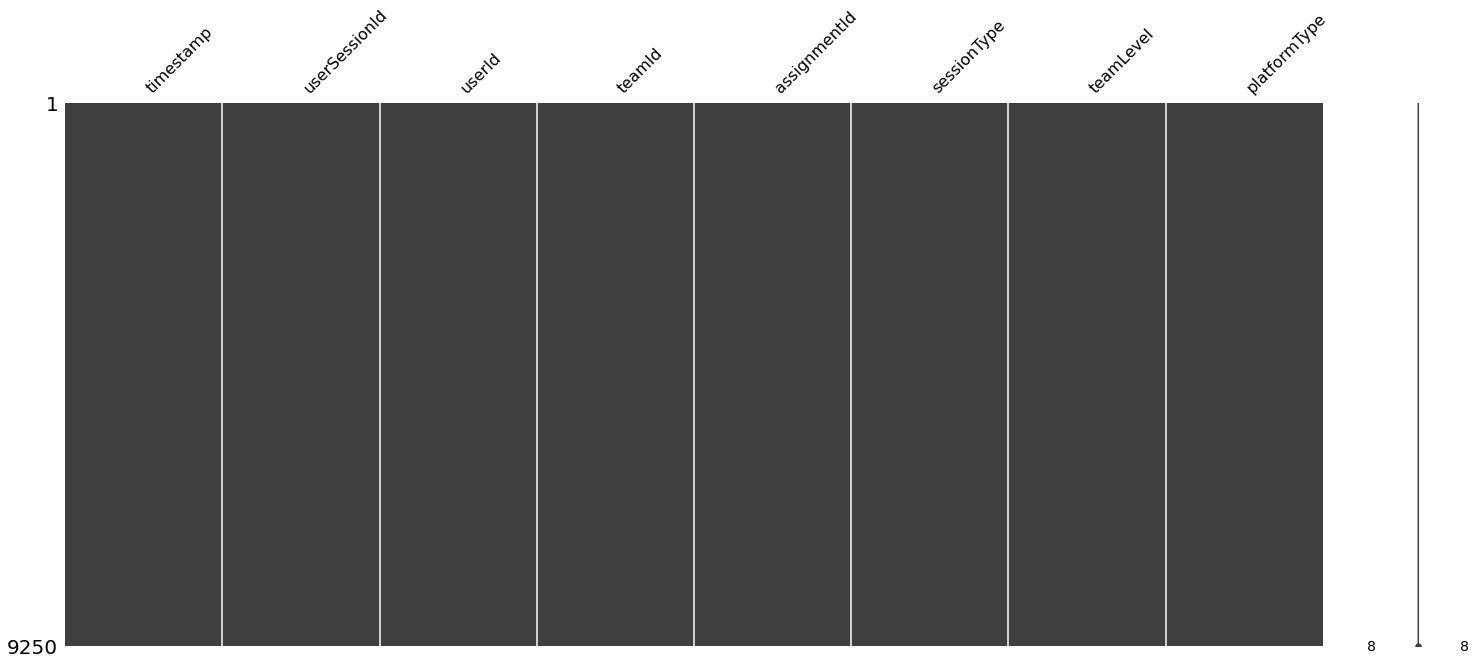

In [43]:
msno.matrix(data_loaded["user_session_pd"])

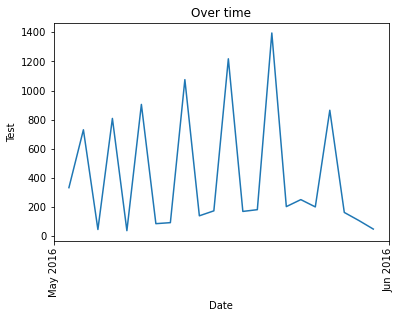

In [44]:
generate_timeseries_plot(data_frame = data_loaded["user_session_pd"], col_1="timestamp", x_label = "Date", y_label = "Test", title = "Over time")

In [45]:
data_loaded["user_session_pd"][["sessionType","platformType"]].head()

,sessionType,platformType
0,start,iphone
1,end,iphone
2,start,android
3,end,android
4,start,iphone


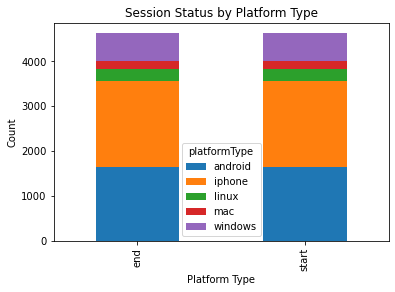

In [46]:
create_histogram_session(data_frame=data_loaded["user_session_pd"][["sessionType","platformType"]])

### users

In [47]:
data_loaded["users_pd"].head()

,timestamp,userId,nick,twitter,dob,country
0,1340117621,442,pcjIOBKW,@SZhyOHv,774662400,BA
1,1340134141,949,vAOfUkf,@nkkNo,41126400,HU
2,1340220899,1654,qOOXSQ,@SwOlw,9331200,IS
3,1340241509,1586,px4gW51,@IrCHTnE,-129600000,AM
4,1340292900,599,9gkfwRC73Uc,@VJj0Az,777600000,CC


<AxesSubplot:>

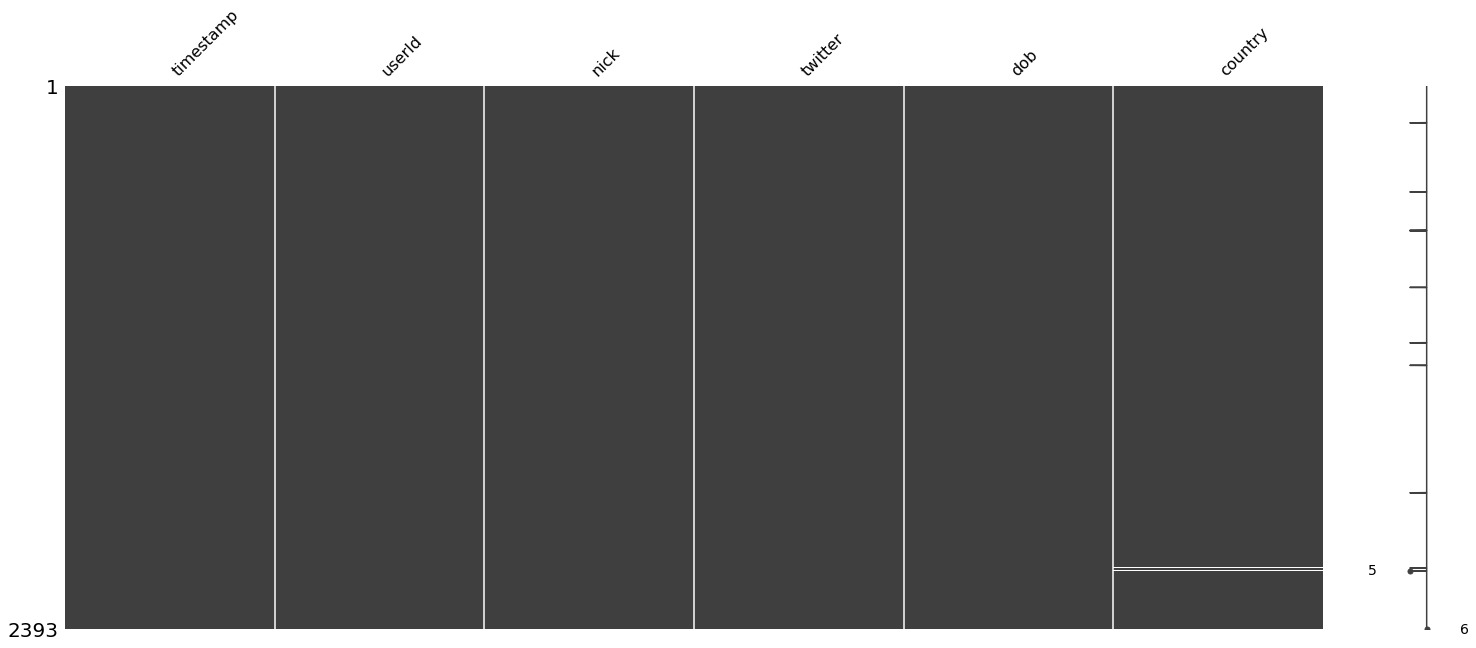

In [48]:
msno.matrix(data_loaded["users_pd"])

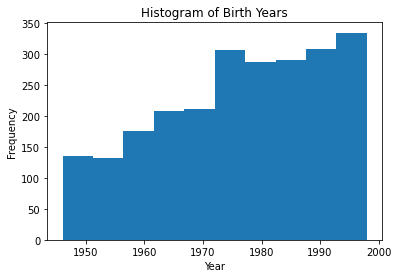

In [49]:
create_dob_histogram(data_frame= convert_unix_to_datetime(data_loaded["users_pd"][["dob"]], "dob")["dob"])

In [7]:
create_world_map()

## Data schema

In [50]:
schema_dict = {
    "ad-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("txId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("adId", IntegerType(), True),\
        StructField("adCategory", StringType(), True)
    ],
    "buy-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("txId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("team", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("buyId", IntegerType(), True),\
        StructField("price", DoubleType(), True)
    ],
    "combined-data" : [
        StructField("userId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("platformType", StringType(), True),\
        StructField("count_gameclicks", IntegerType(), True),\
        StructField("count_hits", IntegerType(), True),\
        StructField("count_buyId", StringType(), True),\
        StructField("avg_price", StringType(), True)
    ],
    "game-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("clickId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("isHit", StringType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True)
    ],
    "level-events" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("eventId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("eventType", StringType(), True)
    ],
    "team-assignments" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("team", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("assignmentId", IntegerType(), True)
    ],
    "team" : [
        StructField("teamId", IntegerType(), True),\
        StructField("name", StringType(), True),\
        StructField("teamCreationTime", IntegerType(), True),\
        StructField("teamEndTime", IntegerType(), True),\
        StructField("strength", FloatType(), True),\
        StructField("currentLevel", IntegerType(), True)
    ],
    "user-session" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("assignmentId", IntegerType(), True),\
        StructField("sessionType", StringType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("platformType", StringType(), True)
    ],
    "users" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("nick", StringType(), True),\
        StructField("twitter", StringType(), True),\
        StructField("dob", IntegerType(), True),\
        StructField("country", StringType(), True)
    ]
}

## Load data

In [51]:
data_ad_clicks = spark.createDataFrame(
                              data_loaded["ad_clicks_pd"], 
                              schema=StructType(schema_dict["ad-clicks"])
                              )

data_buy_clicks = spark.createDataFrame(
                              data_loaded["buy_clicks_pd"], 
                              schema=StructType(schema_dict["buy-clicks"])
                              )

data_combined_data = spark.createDataFrame(
                              data_loaded["combined_data_pd"], 
                              schema=StructType(schema_dict["combined-data"])
                              )

data_game_clicks = spark.createDataFrame(
                              data_loaded["game_clicks_pd"], 
                              schema=StructType(schema_dict["game-clicks"])
                              )

data_level_events = spark.createDataFrame(
                              data_loaded["level_events_pd"], 
                              schema=StructType(schema_dict["level-events"])
                              )

data_team_assignments = spark.createDataFrame(
                              data_loaded["team_assignments_pd"], 
                              schema=StructType(schema_dict["team-assignments"])
                              )

data_team = spark.createDataFrame(
                              data_loaded["team_pd"],
                              schema=StructType(schema_dict["team"])
                              )
                
data_user_session = spark.createDataFrame(
                              data_loaded["user_session_pd"], 
                              schema=StructType(schema_dict["user-session"])
                              )

data_users = spark.createDataFrame(
                              data_loaded["users_pd"], 
                              schema=StructType(schema_dict["users"])
                              )

# Data transformation

In [52]:
def replace_value(df, column, to_replace, replace_with):
  return df.withColumn(column, regexp_replace(col(column), to_replace, replace_with))

def change_datatype(df, column, data_type):
  return df.withColumn(column, col(column).cast(data_type))

In [53]:
data_combined_data = replace_value(data_combined_data, "count_buyId", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "count_buyId", "double")

data_combined_data = replace_value(data_combined_data, "avg_price", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "avg_price", "double")

data_game_clicks = replace_value(data_game_clicks, "isHit", "0", "False")
data_game_clicks = replace_value(data_game_clicks, "isHit", "1", "True")
data_game_clicks = change_datatype(data_game_clicks, "isHit", "boolean")

# Testing

In [54]:
data_ad_clicks.show(truncate=False)
data_ad_clicks.printSchema()

data_buy_clicks.show()
data_buy_clicks.printSchema()

data_combined_data.show()
data_combined_data.printSchema()

data_game_clicks.show()
data_game_clicks.printSchema()

data_level_events.show()
data_level_events.printSchema()

data_team_assignments.show()
data_team_assignments.printSchema()

data_team.show()
data_team.printSchema()

data_user_session.show()
data_user_session.printSchema()

data_users.show()
data_users.printSchema()

+----------+----+-------------+------+------+----+-----------+
|timestamp |txId|userSessionId|teamId|userId|adId|adCategory |
+----------+----+-------------+------+------+----+-----------+
|1464275602|5974|5809         |27    |611   |2   |electronics|
|1464275844|5976|5705         |18    |1874  |21  |movies     |
|1464276172|5978|5791         |53    |2139  |25  |computers  |
|1464276177|5973|5756         |63    |212   |10  |fashion    |
|1464276178|5980|5920         |9     |1027  |20  |clothing   |
|1464276439|5977|5954         |77    |595   |4   |games      |
|1464276531|5981|5674         |54    |770   |6   |movies     |
|1464276925|5975|5919         |59    |2133  |3   |electronics|
|1464276937|5979|5945         |75    |253   |3   |electronics|
|1464276998|5972|5914         |78    |1821  |12  |computers  |
|1464277122|6000|5955         |64    |2009  |17  |games      |
|1464277303|6001|5892         |53    |1538  |21  |movies     |
|1464277390|5999|5705         |18    |1874  |3   |elect